# 1. Uczenie klasyfikatora

Trochę informacji: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

In [47]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.pipeline import make_pipeline
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import sklearn.metrics

In [48]:
##selected classses
classes = ["Lemon", "Raspberry", "Mandarine", "Pear 2", "Apple Red 1", "Strawberry", "Pomegranate", "Pepino", "Kaki", "Apricot", "Ginger Root", "Huckleberry"]

In [49]:
##load with rescaling so that size was OK, batch_size=1, we will create batches later, color, classes..
trdata_gen = ImageDataGenerator(rescale=1./255)
traindata = trdata_gen.flow_from_directory(directory="../data/LessClasses/Training",target_size=(224,224), batch_size=1,color_mode="rgb", classes=classes,class_mode="categorical", shuffle=False) 

Found 9792 images belonging to 12 classes.


In [50]:
vdata_gen = ImageDataGenerator(rescale=1./255)
valdata = vdata_gen.flow_from_directory(directory="../data/LessClasses/Validation",target_size=(224,224), batch_size=1,color_mode="rgb", classes=classes,class_mode="categorical", shuffle=False) 

Found 1732 images belonging to 12 classes.


In [51]:
traindata.class_indices

{'Lemon': 0,
 'Raspberry': 1,
 'Mandarine': 2,
 'Pear 2': 3,
 'Apple Red 1': 4,
 'Strawberry': 5,
 'Pomegranate': 6,
 'Pepino': 7,
 'Kaki': 8,
 'Apricot': 9,
 'Ginger Root': 10,
 'Huckleberry': 11}

In [52]:
CLASSES = len(traindata.class_indices)

In [53]:
tsdata_gen = ImageDataGenerator(rescale=1./255)
testdata = tsdata_gen.flow_from_directory(directory="../data/LessClasses/Test", target_size=(224,224),batch_size=1, color_mode="rgb", classes=classes,class_mode="categorical", shuffle=False)

Found 1981 images belonging to 12 classes.


In [54]:
## our sweet NN
base_model = VGG16(weights='imagenet', include_top = False , input_shape=(224,224, 3))
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [55]:
##TO CHECK OUT- LEAVE ONLY LAST ON
flatten= Flatten()(base_model.layers[-1].output)
# add new classifier layers
# class_dense = Dense(1024, activation='relu')(flatten) 
output = Dense(CLASSES, activation='softmax')(flatten)
# define new model
## maybe add dropout and maybe one more dense
model_pretrained = Model(inputs=base_model.inputs, outputs=output)
# summarize
model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [56]:
##freeze all  base_model layers and train the last ones
for layer in base_model.layers:
    layer.trainable = False

In [57]:
model_pretrained.compile(optimizer='rmsprop', ##adam?
              loss='categorical_crossentropy',
              metrics=['acc'])

In [75]:
EPOCHS = 40
BATCH_SIZE = 64
STEPS_PER_EPOCH = 64
VALIDATION_STEPS = 64

In [76]:
file_string = 'ex-1a-40-64-full-full'
MODEL_FILE = 'models/'+ file_string +'.model' # numbers correspond to above values
print(MODEL_FILE)

models/ex-1a-40-64-full-full.model


In [77]:
model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
checkpoint = ModelCheckpoint("vgg16_1_pretrained.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=20, verbose=1, mode='auto')
#csv_logger = CSVLogger('./results/vgg16imagenetpretrained.csv')

In [79]:
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
history_pretrained = model_pretrained.fit(
    traindata,
    epochs=EPOCHS,
    steps_per_epoch=len(traindata)/BATCH_SIZE,
    validation_steps=len(valdata)/BATCH_SIZE,
    validation_data=valdata,
    shuffle=True,
    callbacks=[checkpoint, early_stopper]
)


model_pretrained.save(MODEL_FILE)

Epoch 1/40
153/153 [==============================] - 30s 194ms/step - loss: 0.1647 - acc: 0.9673 - val_loss: 0.0000e+00 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to vgg16_1_pretrained.h5
Epoch 2/40
153/153 [==============================] - 34s 225ms/step - loss: 0.0741 - acc: 0.9869 - val_loss: 7.6635e-08 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/40
153/153 [==============================] - 36s 234ms/step - loss: 0.0444 - acc: 0.9739 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/40
153/153 [==============================] - 35s 226ms/step - loss: 0.2262 - acc: 0.9281 - val_loss: 0.0000e+00 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/40
153/153 [==============================] - 35s 230ms/step - loss: 0.1337 - acc: 0.9673 - val_loss: 0.0000e+00 - val_acc: 1.0000

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6/40

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


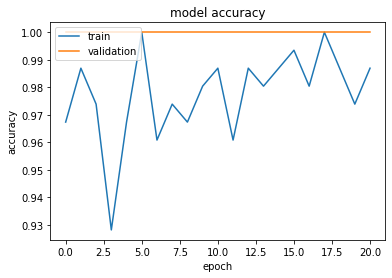

In [80]:
print(history_pretrained.history.keys())
plt.plot(history_pretrained.history['acc'])
plt.plot(history_pretrained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('./plots/'+file_string + '_acc_training_process.png')
plt.show()

In [81]:
from keras.models import load_model

In [82]:
MODEL_FILE = 'ex-1a-40-64-full-full.model'

In [83]:
# Load desired model
model = load_model('./models/' + MODEL_FILE)

In [84]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [85]:
y_train = traindata.labels
y_test = testdata.labels

In [86]:
y_pred_train = model.predict(traindata, workers=-1, use_multiprocessing=True, verbose=1)
y_pred_test = model.predict(testdata, workers=-1, use_multiprocessing=True, verbose=1)

1981/1981 [==============================] - 403s 203ms/step


In [87]:
report_train = sklearn.metrics.classification_report(y_train, np.argmax(y_pred_train, axis=1))
report_test = sklearn.metrics.classification_report(y_test, np.argmax(y_pred_test, axis=1))

# Training set report

In [88]:
print(report_train)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       819
           1       1.00      1.00      1.00       817
           2       0.99      1.00      1.00       813
           3       1.00      0.99      1.00       827
           4       0.95      1.00      0.97       815
           5       1.00      1.00      1.00       814
           6       1.00      0.93      0.96       816
           7       1.00      0.99      1.00       820
           8       1.00      0.99      1.00       815
           9       0.95      1.00      0.98       820
          10       1.00      1.00      1.00       800
          11       1.00      1.00      1.00       816

    accuracy                           0.99      9792
   macro avg       0.99      0.99      0.99      9792
weighted avg       0.99      0.99      0.99      9792



# Test set report 

In [89]:
print(report_test)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       164
           1       1.00      1.00      1.00       166
           2       0.84      1.00      0.91       166
           3       1.00      0.48      0.65       232
           4       0.59      1.00      0.75       164
           5       1.00      1.00      1.00       164
           6       0.86      0.92      0.89       164
           7       1.00      0.70      0.83       166
           8       1.00      0.99      1.00       166
           9       0.99      1.00      0.99       164
          10       1.00      1.00      1.00        99
          11       1.00      1.00      1.00       166

    accuracy                           0.91      1981
   macro avg       0.93      0.93      0.91      1981
weighted avg       0.93      0.91      0.90      1981



# Save reports

In [90]:
from joblib import dump, load 

In [91]:
dump(report_train, './results/report-train-' + MODEL_FILE + '.joblib')
dump(report_test, './results/report-test-' + MODEL_FILE + '.joblib')

['./results/report-test-ex-1a-40-64-full-full.model.joblib']